<a id='top'></a>
<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:200%;text-align:center;border-radius:200px 10px;">TABLE OF CONTENTS</p>  

- [1. Imports](#1)
- [2. Hyperparameters](#2)
- [3. Helper Functions](#3)
- [4. Dataset](#4)
  * .[4.1 Feature Extractor and Tokenizer](#4.4)
  * [4.2 Transforms and dataframe](#4.1)
  * [4.3 Dataset Class](#4.2)
  * .[4.4 Train and validation dataset](#4.3)
- [5. Model Building](#5)
    * .[5.1 Model Initialization](#5.2)
- [6. Training](#6)
    * .[6.1 Training Arguments](#6.1)
    * .[6.2 Training using Seq2SeqTrainer](#6.2)
- .[7. Predictions](#7)

In [1]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

<a id="1"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">1. IMPORTS 📂</p>
#### [Top ↑](#top)

In [2]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<a id="2"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">2. HYPERPARAMETERS</p>
#### [Top ↑](#top)

In [5]:
os.environ["WANDB_DISABLED"] = "true"
class config: 
    # google/vit-base-patch16-224 is pre-trained on
    # ImageNet-21k (14 million images, 21,843 classes)
    # at resolution 224x224, and fine-tuned on ImageNet 2012 
    # (1 million images, 1,000 classes) at resolution 224x224,
    # more info at https://huggingface.co/google/vit-base-patch16-224 
    ENCODER = "WinKawaks/vit-small-patch16-224"
    DECODER = "gpt2-medium"
    TRAIN_BATCH_SIZE = 4
    VAL_BATCH_SIZE = 4
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 13
    SUMMARY_LEN = 13
    WEIGHT_DECAY = 0.01
    # Mean of the ImageNet dataset (R,G,B)
    MEAN = (0.485, 0.456, 0.406)
    # Std of the ImageNet dataset (R,G,B)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.8
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 4
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 50
    TOP_P = 1

<a id="3"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">3. HELPER FUNCTIONS</p>
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> There are Two helper functions:  </span></font>
1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The first function is to <b>build special tokens</b> while tokenizing the captions  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The second function is used to compute the <b>ROUGE-2</b> metrics as we are working with Transformers  </span></font>

In [6]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [7]:
import nltk
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    pred_bleu = [line.split() for line in pred_str]
    label_bleu = []

    for item in label_str:
        label_bleu.append([])
        label_bleu[-1].append(item.split())
        
    rouge1_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge2_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    bleu_output = nltk.translate.bleu_score.corpus_bleu(label_bleu, pred_bleu)
    return {
        "rouge1_precision": round(rouge1_output.precision, 4),
        "rouge1_recall": round(rouge1_output.recall, 4),
        "rouge1_fmeasure": round(rouge1_output.fmeasure, 4),
        "rouge2_precision": round(rouge2_output.precision, 4),
        "rouge2_recall": round(rouge2_output.recall, 4),
        "rouge2_fmeasure": round(rouge2_output.fmeasure, 4),
        "bleu_score": round(bleu_output, 4)
    }


<a id="4"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">4. DATASET</p>


<a id="4.4"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.1 Feature Extractor and Tokenizer : </span></font>
#### [Top ↑](#top)

1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The Feature extractor is loaded using <b>ViTFeatureExtractor</b>  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The tokenizer for GPT2 is loaded using the <b>AutoTokenizer</b>  </span></font>

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

<a id="4.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.2 Transforms and dataframe : </span></font>
#### [Top ↑](#top)

 <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The Transformations used are </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Resizing</b> the image to (224,224) </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">Converting the image to <b>Tensor</b></span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> <b>Normalizing</b> the image </span></font>

In [9]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/kaggle/input/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

<a id="4.2"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.3 Dataset Class : </span></font>
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The dataset is created using the following steps </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">We read the image using the <b>Image</b> function of PIL library </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The image is <b>transformed</b> using the transformed defined above</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The transformed image is passed through the <b>feature extractor</b> to extract the pixel values from the image </span></font>
4. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The captions are loaded from the dataframe</span></font>
5. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The captions are <b>tokenized</b></span></font>
6. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The tokenized captions are <b>padded</b> to max length</span></font>
7. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The images and tokenized captions are returned</span></font>

In [10]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        # Get caption and image at row idx in dataframe
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        # Get image path by joining root directory with image file name
        img_path = os.path.join(self.root_dir , image)
        # Open the image and convert to RGB
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            # transform the image
            img= self.transform(img)
        # feature extractors will return PyTorch (pt) tensors that can be 
        # fed to the model
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        
        # Learn more about GPT-2 Tokenizer at 
        # https://lukesalamone.github.io/posts/gpt2-tokenization/
        
        # each caption will padded to max_length of 50 tokens
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids

        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        # Return the encoding of image and caption at index idx
        return encoding
        
        

<a id="4.3"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.4 Train and validation dataset: </span></font>
#### [Top ↑](#top)

In [11]:
train_dataset = ImgDataset(train_df, root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

<a id="5"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">5. MODEL BUILDING</p>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">ENCODER</p>
<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</span></font>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">DECODER</p>
<br> 

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</span></font>
    
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</span></font>
    

<a id="5.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">5.1 Model Initialization : </span></font>
#### [Top ↑](#top)

In [12]:
# The VisionEncoderDecoderModel can be used to initialize an image-to-text
# model with any pretrained Transformer-based vision model as the encoder
# (e.g. ViT, BEiT, DeiT, Swin) and any pretrained language model as the
# decoder (e.g. RoBERTa, GPT2, BERT, DistilBERT).
# More info at https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125M [00:00<?, ?B/s]

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.17.crossattention.c_attn.weight', 'h.1.ln_cross_attn.weight', 'h.6.crossattention.c_proj.weight', 'h.12.crossattention.bias', 'h.11.crossattention.masked_bias', 'h.3.crossattention.q_attn.weight', 'h.13.crossattention.c_proj.weight', 'h.12.crossattention.c_proj.bias', 'h.3.crossattention.bias', 'h.0.ln_cross_attn.weight', 'h.15.crossattention.c_proj.weight', 'h.19.crossattention.bias', 'h.0.crossattention.c_proj.bias', 'h.7.crossattention.masked_bias', 'h.13.crossattention.bias', 'h.6.crossattention.c_proj.bias', 'h.19.ln_cross_attn.weight', 'h.22.crossattention.c_proj.weight', 'h.6.crossattention.c_attn.weight', 'h.12.crossattention.masked_bias', 'h.0.crossattention.masked_bias', 'h.23.crossattention.q_attn.weight', 'h.3.crossattention.masked_bias', 'h.5.crossattention.c_proj.weight', 'h.16.crossattention.masked_bias', 'h.21.crossattention.c_attn.weight', 'h.21.

In [13]:
# cls_token: a special token representing the class of the input
# (used by BERT for instance)
model.config.decoder_start_token_id = tokenizer.cls_token_id
# pad_token: a special token used to make arrays of tokens the same size
# for batching purpose. Will then be ignored by attention mechanisms
# or loss computation
model.config.pad_token_id = tokenizer.pad_token_id
# vocab_size: Vocabulary size of the GPT-2 model (default to 50257)
# Defines the number of different tokens that can be represented
# by the inputs_ids
# Source: https://huggingface.co/docs/transformers/model_doc/gpt2
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
# More info at: https://huggingface.co/transformers/v4.10.1/main_classes/model.html

# A special token separating two different sentences in the same input
# (used by BERT for instance)
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
# max_length: maximum length of the sequence to be generated
model.config.max_length = 13
# early_stopping: whether to stop the beam search when at least
# num_beams sentences are finished per batch or not.
model.config.early_stopping = True
# no_repeat_ngram_size: if set to int > 0, all ngrams of that size
# can only occur once.
model.config.no_repeat_ngram_size = 2
# length_penalty: Exponential penalty to the length. 1.0 means no penalty.
# Set to values < 1.0 in order to encourage the model to generate
# shorter sequences, to a value > 1.0 in order to encourage the model
# to produce longer sequences.
model.config.length_penalty = 1.2
# num_beams: number of beams for beam search. 1 means no beam search.
model.config.num_beams = 6

<a id="6"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">6. TRAINING</p>

<a id="6.1"></a>
### <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">6.1 Training Arguments : </span></font>
#### [Top ↑](#top)

In [14]:
# Use Huggingface Seq2SeqTrainer for training:
# https://huggingface.co/docs/transformers/main_classes/trainer
training_args = Seq2SeqTrainingArguments(
    # output_dir: The output directory where the model predictions
    # and checkpoints will be written.
    output_dir='VIT_large_gpt2',
    # per_device_train_batch_size: The batch size per GPU core/CPU for training.
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    # per_device_train_batch_size: The batch size per GPU core/CPU for evaluation.
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    # predict_with_generate: Whether to use generate to calculate
    # generative metrics (ROUGE, BLEU).
    predict_with_generate=True,
    evaluation_strategy="epoch", # Evaluation is done at the end of each epoch.
    do_train=True, # Whether to run training or not
    do_eval=True, # Whether to run evaluation on the validation set or not
    logging_steps=1024, # Number of update steps between two logs
    save_steps=2048, # Number of updates steps before two checkpoint saves 
    warmup_steps=1024, # Number of steps used for a linear warmup from 0 to learning_rate
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,# limit the total amount of checkpoints
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


<a id="6.2"></a>
### <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">6.2 Training using Seq2SeqTrainer : </span></font>
#### [Top ↑](#top)

In [15]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32364
  Num Epochs = 4
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 32364


Saving model checkpoint to VIT_large_gpt2/checkpoint-2048
Configuration saved in VIT_large_gpt2/checkpoint-2048/config.json
Model weights saved in VIT_large_gpt2/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-2048/preprocessor_config.json
Saving model checkpoint to VIT_large_gpt2/checkpoint-4096
Configuration saved in VIT_large_gpt2/checkpoint-4096/config.json
Model weights saved in VIT_large_gpt2/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_large_gpt2/checkpoint-2048] due to args.save_total_limit
Saving model checkpoint to VIT_large_gpt2/checkpoint-6144
Configuration saved in VIT_large_gpt2/checkpoint-6144/config.json
Model weights saved in VIT_large_gpt2/checkpoint-6144/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-6144/preprocessor_config.json
Deleting older checkpoint [VIT_large_gpt2/checkpoint-4096] due to args.save

TrainOutput(global_step=32364, training_loss=1.7996625248455556, metrics={'train_runtime': 22038.2105, 'train_samples_per_second': 5.874, 'train_steps_per_second': 1.469, 'total_flos': 4.972979397523931e+19, 'train_loss': 1.7996625248455556, 'epoch': 4.0})

In [16]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json


<a id="7"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">7. PREDICTIONS</p>
#### [Top ↑](#top)

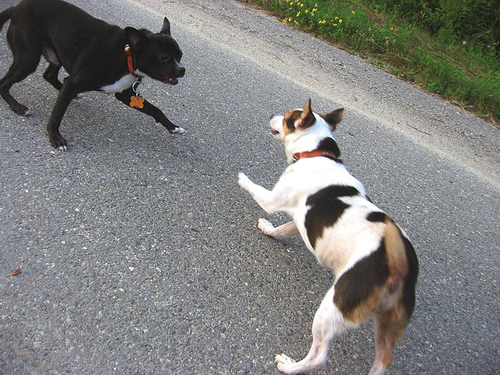

In [17]:
img =  Image.open("/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [18]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>Two dogs are playing together on the road. one dog is


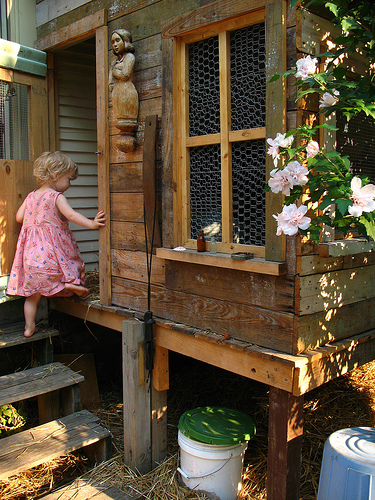

In [19]:
img =  Image.open("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [20]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A little girl in a pink dress stands in front of a


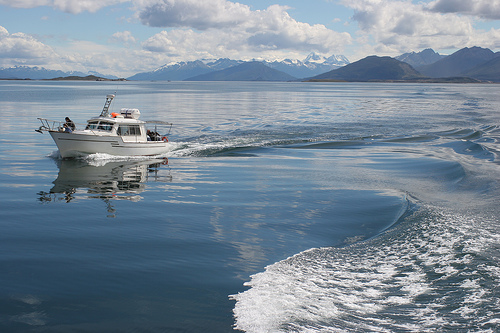

In [21]:
img =  Image.open("/kaggle/input/flickr8k/Images/90011335_cfdf9674c2.jpg").convert("RGB")
img

In [22]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A man sits in a boat on the shore of a lake


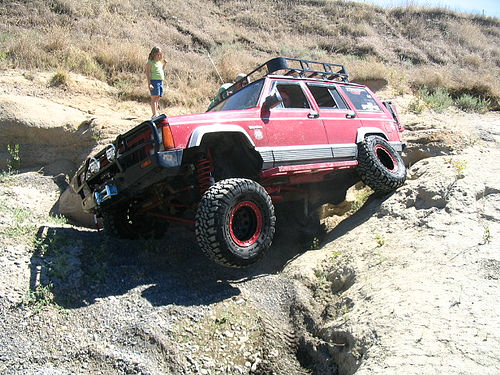

In [23]:
img =  Image.open("/kaggle/input/flickr8k/Images/36422830_55c844bc2d.jpg").convert("RGB")
img

In [24]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A man drives a red ATV over rough terrain. The


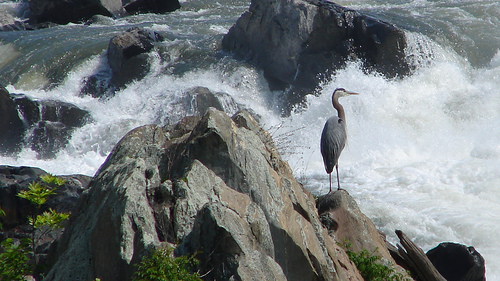

In [25]:
img =  Image.open("/kaggle/input/flickr8k/Images/145721496_687af9bb18.jpg").convert("RGB")
img

In [26]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A black and white bird standing on top of a mountain.


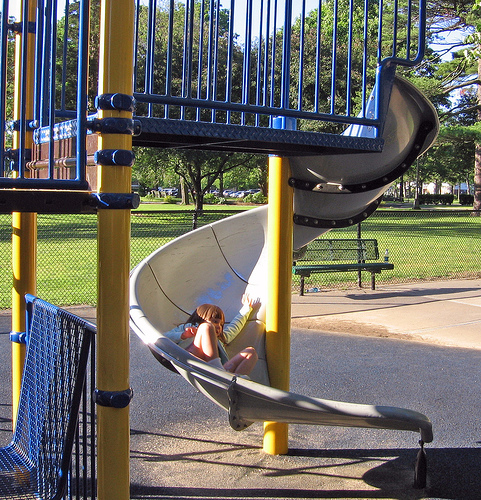

In [27]:
img =  Image.open("/kaggle/input/flickr8k/Images/170100272_d820db2199.jpg").convert("RGB")
img

In [28]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A little boy slides down a yellow slide at a playground.


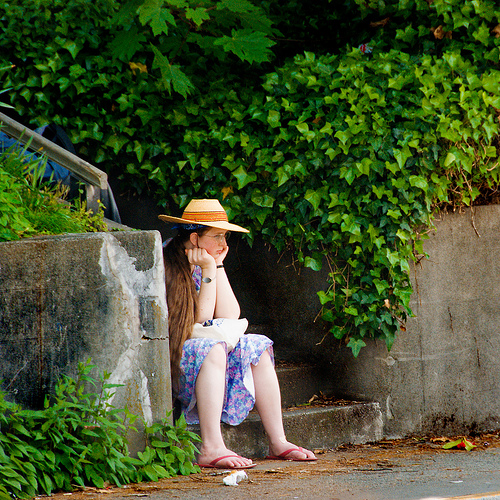

In [29]:
img =  Image.open("/kaggle/input/flickr8k/Images/2508249781_36e9282423.jpg").convert("RGB")
img

In [30]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A young woman wearing a straw hat and a white shirt is


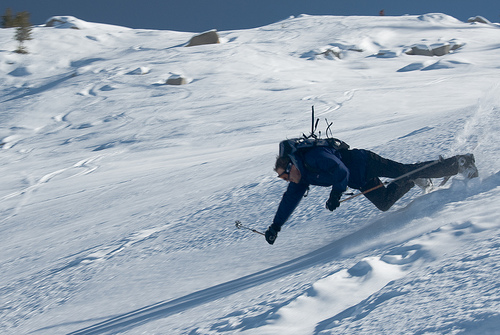

In [31]:
img =  Image.open("/kaggle/input/flickr8k/Images/3248220732_0f173fc197.jpg").convert("RGB")
img

In [32]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A skier is falling face first into the snow. Another


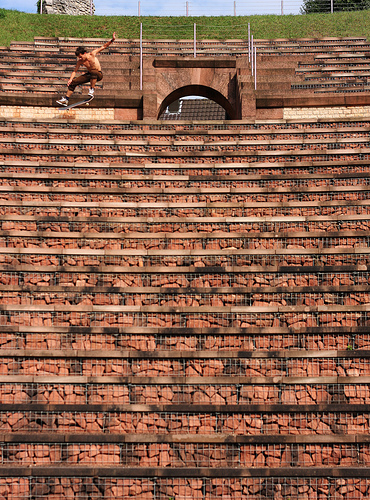

In [33]:
img =  Image.open("/kaggle/input/flickr8k/Images/3718305988_fe2c91fd44.jpg").convert("RGB")
img

In [34]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption+ '\033[0m')

<|endoftext|>A boy in a brown shirt is skateboarding on a brick


# <center><font size = 3><span style="color:#F6923D"><b> Thank You for reading 😊<br>If you have any suggestions or feeback, please let me know</b></span></font></center>
#### [Top ↑](#top)